In [1]:
from tinyai import *

In [2]:
import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

In [3]:
from datasets import load_dataset

dsd = load_dataset("fashion_mnist")

x,y = 'image','label'

xmean,xstd = 0.28, 0.35
@inplace
def transformi(b): b[x] = [(TF.to_tensor(o)-xmean)/xstd for o in b[x]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=8)

In [ ]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.1

    # 28, 14, 7, 4, 2, 1
    hdims = (16, 32, 64, 128, 256, 512)

    layers: list[nn.Module] = [
        ResBlock(1, hdims[0], ks=5, stride=1, act=act, norm=norm),
        nn.Dropout2d(p=drop),
    ]  # 14x14
    for fi, fo in zip(hdims, hdims[1:]):
        layers.append(ResBlock(fi, fo, stride=2, act=act, norm=norm))
    layers.extend(
        [
            nn.Flatten(),
            nn.Dropout(p=0.25),
            nn.Linear(hdims[-1], 10, bias=False),
            nn.BatchNorm1d(10),
        ]
    )
    return nn.Sequential(*layers)


def get_learner():
    set_seed(1337)
    iw = partial(init_weights, leaky=0.1)
    model = get_model().apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, opt_func=optim.AdamW)

In [5]:
learn = get_learner()
learn.summary()

Tot params: 4905572; MFLOPS: 22.0


/Users/tom/fun/tinyai/tinyai/nn/functional.py:9: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1694493834224/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  target = F.one_hot(target).to(torch.int32).float()


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(256, 1, 28, 28)|(256, 16, 28, 28)|6896|5.3|
|Dropout2d|(256, 16, 28, 28)|(256, 16, 28, 28)|0|0.0|
|ResBlock|(256, 16, 28, 28)|(256, 32, 14, 14)|14496|2.8|
|ResBlock|(256, 32, 14, 14)|(256, 64, 7, 7)|57664|2.8|
|ResBlock|(256, 64, 7, 7)|(256, 128, 4, 4)|230016|3.7|
|ResBlock|(256, 128, 4, 4)|(256, 256, 2, 2)|918784|3.7|
|ResBlock|(256, 256, 2, 2)|(256, 512, 1, 1)|3672576|3.7|
|Flatten|(256, 512, 1, 1)|(256, 512)|0|0.0|
|Dropout|(256, 512)|(256, 512)|0|0.0|
|Linear|(256, 512)|(256, 10)|5120|0.0|
|BatchNorm1d|(256, 10)|(256, 10)|20|0.0|


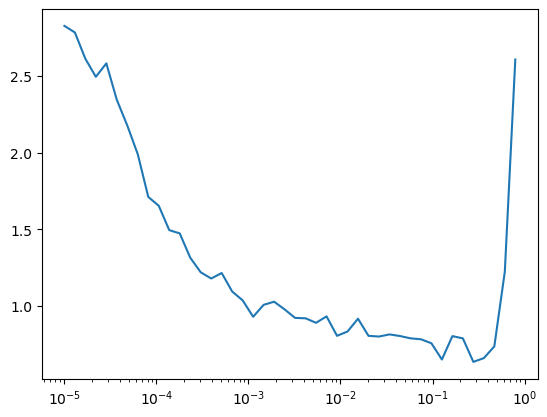

In [6]:
learn.lr_find()

In [7]:
from torchvision import transforms
from torcheval.metrics import MulticlassAccuracy

tfms = nn.Sequential(
    # transforms.RandomCrop(size=28, padding=2, fill=xmean),
    # transforms.RandomHorizontalFlip(),
    # RandomErase(max_n=10, pct=0.2),
)


def im_tfms(b):
    xb, yb = b
    return tfms(xb), yb

tfmcb = BatchTransformCB(im_tfms, valid=False)
astats = ActivationStats()

epoch,train,loss,accuracy
0,train,0.6084,0.8442
0,eval,0.4670,0.8482
1,train,0.3344,0.8920
1,eval,0.3600,0.8737
2,train,0.2463,0.9164
2,eval,0.2502,0.9119
3,train,0.1861,0.9359
3,eval,0.2025,0.9301
4,train,0.1295,0.9569
4,eval,0.2003,0.9315


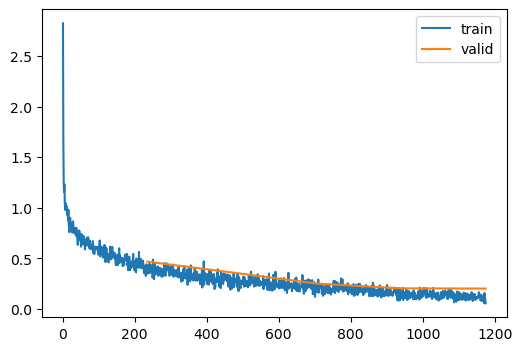

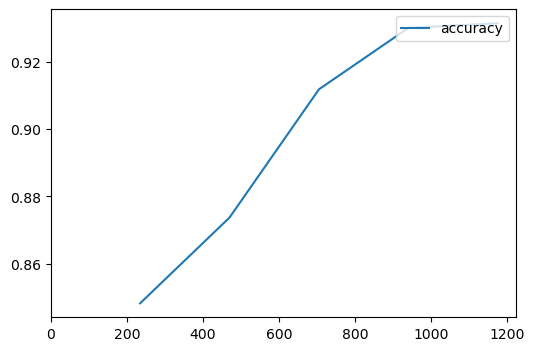

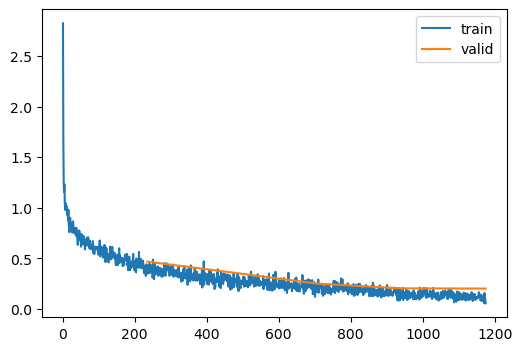

In [8]:
learn = get_learner()
learn.fit_one_cycle(5, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), astats, tfmcb])

/Users/tom/fun/tinyai/tinyai/cbs.py:497: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:514: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tom/fun/tinyai/tinyai/cbs.py:504: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


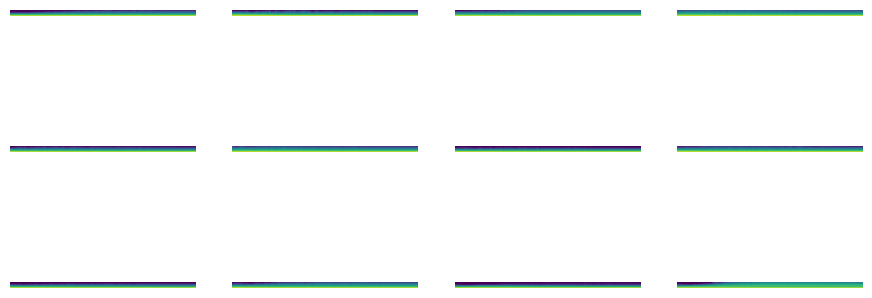

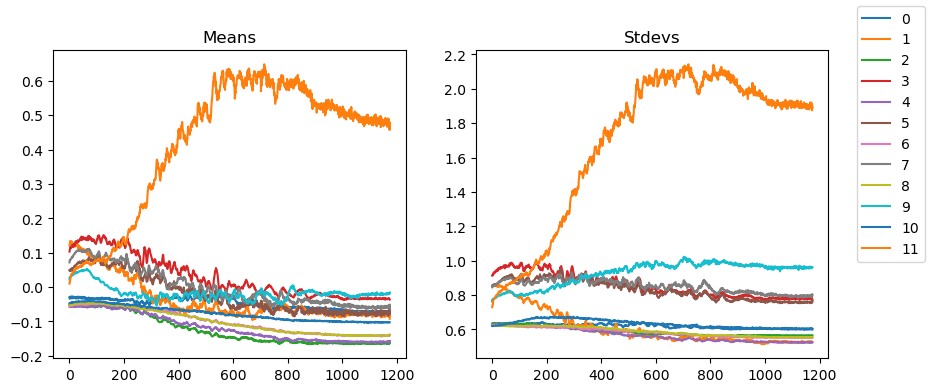

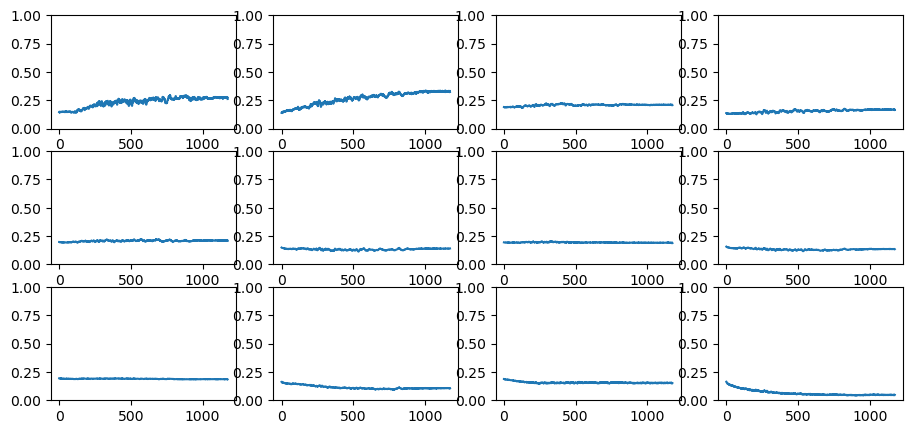

In [9]:
astats.plot_all()

So we get 93% accuracy in 5 epochs, lets try adjusting the OneCycle

In [10]:
from torch.optim import lr_scheduler

max_lr = 1e-2
tmax = 5 * len(dls.train)
pct_start = 0.1
anneal_strategy="cos" # 0.9340 with linear, 0.9339 with cos!
sched = partial(lr_scheduler.OneCycleLR, max_lr=max_lr, total_steps=tmax, pct_start=pct_start, anneal_strategy=anneal_strategy)

schedcb = BatchSchedCB(sched)

epoch,train,loss,accuracy
0,train,0.5365,0.8481
0,eval,0.3624,0.8708
1,train,0.2928,0.9004
1,eval,0.3061,0.8930
2,train,0.2247,0.9229
2,eval,0.2296,0.9171
3,train,0.1701,0.9418
3,eval,0.2083,0.9306
4,train,0.1211,0.9598
4,eval,0.1983,0.9339


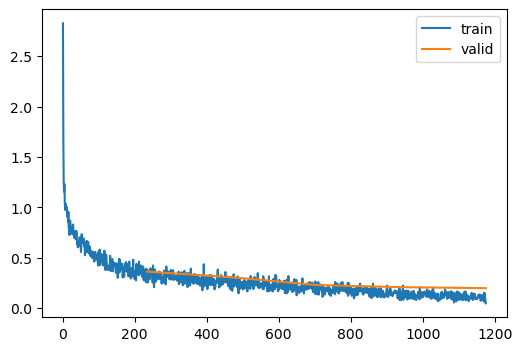

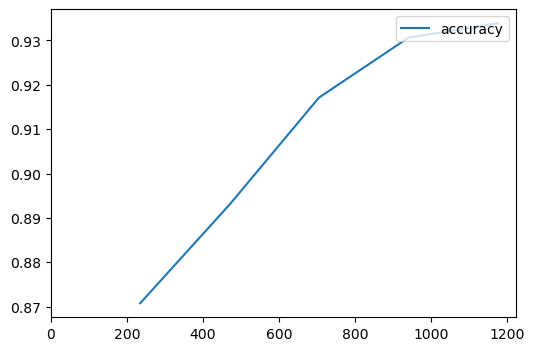

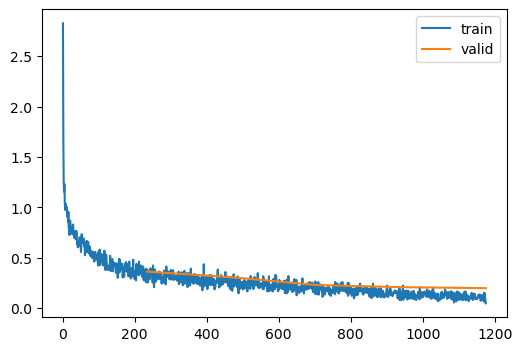

In [11]:
learn = get_learner()
learn.fit(5, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), astats, tfmcb, schedcb])

## Dropout

In [12]:
from functools import partial
from torch import nn
from torch import optim


def get_model():
    act = partial(GeneralReLU, leak=0.1, sub=0.4)
    # act = nn.ReLU
    norm = nn.BatchNorm2d
    drop = 0.25

    layers = [
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm),
        ResBlock(16, 32, stride=2, act=act, norm=norm),
        ResBlock(32, 64, stride=2, act=act, norm=norm),
        ResBlock(64, 128, stride=2, act=act, norm=norm),
        ResBlock(128, 256, stride=2, act=act, norm=norm),
        nn.Dropout(p=drop),
        ResBlock(256, 512, stride=2, act=act, norm=norm),
        nn.Dropout(p=drop),
        nn.Flatten(),
        nn.Linear(512, 10, bias=False),
        nn.BatchNorm1d(10),
    ]
    return nn.Sequential(*layers)


def get_learner():
    set_seed(1337)
    iw = partial(init_weights, leaky=0.1)
    model = get_model().apply(iw)
    return Trainer(model, dls, loss_func=cross_entropy, opt_func=optim.AdamW)

epoch,train,loss,accuracy
0,train,0.5258,0.8540
0,eval,0.4001,0.8639
1,train,0.2891,0.9031
1,eval,0.3318,0.8825
2,train,0.2252,0.9223
2,eval,0.2388,0.9131
3,train,0.1707,0.9414
3,eval,0.2057,0.9300
4,train,0.1197,0.9610
4,eval,0.1969,0.9346


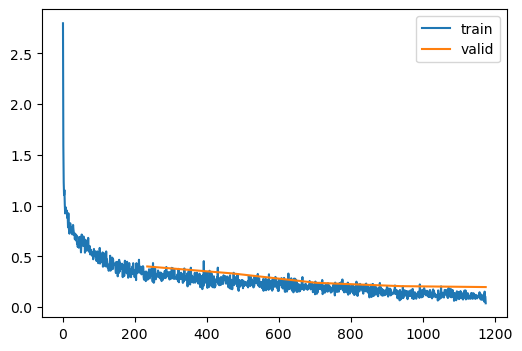

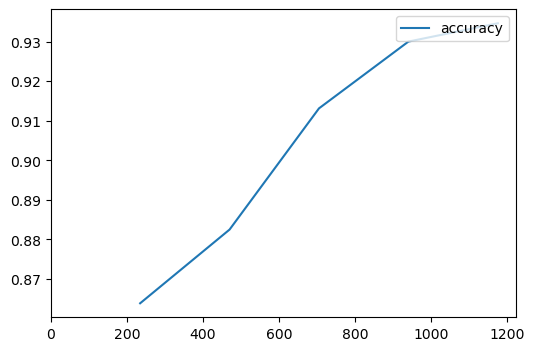

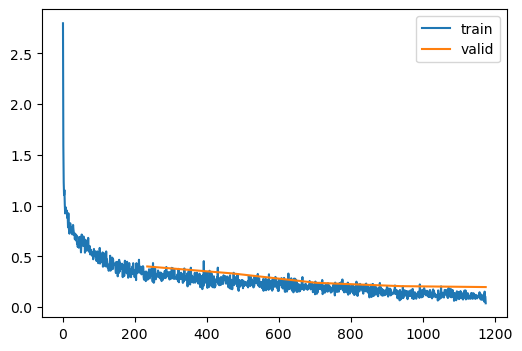

In [13]:
learn = get_learner()
learn.fit(5, lr=1e-2, cbs=[MetricsCB(accuracy=MulticlassAccuracy()), PlotMetricsCB(), astats, tfmcb, schedcb])

In [14]:
class SavePreds(Callback):
    def before_epoch(self):
        self.preds = []
        self.targs = []

    def after_batch(self, learn):
        self.preds.append(learn.preds)
        self.preds.append(learn.batch[-1])